In [21]:
import numpy as np
import os
import random
import shutil
import seaborn as sns
import tempfile
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
import kagglehub

path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [6]:
DATASET_PATH = path + "/PlantVillage"

classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"Found {len(classes)} classes: {classes}")

IMAGE_SIZE = (224, 224) # Image size for MobileNetV2
BATCH_SIZE = 32

BASE_TEMP_DIR = 'temp_data'
TRAIN_DIR = os.path.join(BASE_TEMP_DIR, 'train')
VAL_DIR = os.path.join(BASE_TEMP_DIR, 'validation')
TEST_DIR = os.path.join(BASE_TEMP_DIR, 'test')

if os.path.exists(BASE_TEMP_DIR):
    shutil.rmtree(BASE_TEMP_DIR)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the [0, 1] range
    rotation_range=20,  # Randomly rotate images within a range of 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformations using the nearest pixel values
    validation_split=VAL_SPLIT + TEST_SPLIT  # Reserve a portion of the data for validation and testing
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

all_files = []
all_labels = []
for i, cls in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(class_path):
        all_files.append(os.path.join(class_path, img_name))
        all_labels.append(cls)

train_files, val_test_files, train_labels, val_test_labels = train_test_split(
    all_files, all_labels, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=SEED, stratify=all_labels
)

val_files, test_files, val_labels, test_labels = train_test_split(
    val_test_files, val_test_labels, test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)), random_state=SEED, stratify=val_test_labels
)

print(f"Number of files in the training set: {len(train_files)}")
print(f"Number of files in the validation set: {len(val_files)}")
print(f"Number of files in the test set: {len(test_files)}")

def copy_files_to_temp_dir(file_list, label_list, base_temp_dir):
    for file_path, label in zip(file_list, label_list):
        dest_dir = os.path.join(base_temp_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(file_path, dest_dir)

print("Copying training files...")
copy_files_to_temp_dir(train_files, train_labels, TRAIN_DIR)
print("Copying validation files...")
copy_files_to_temp_dir(val_files, val_labels, VAL_DIR)
print("Copying test files...")
copy_files_to_temp_dir(test_files, test_labels, TEST_DIR)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Using 'categorical' because there is many classes
    seed=SEED
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False # Important for model evaluation - for keeping same order
)

print("Data generators created.")

NUM_CLASSES = train_generator.num_classes
print(f"asses in the training generator: {NUM_CLASSES}")
print("Mapping indexes to class names:")
train_generator.class_indices

Found 15 classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of files in the training set: 16511
Number of files in the validation set: 2064
Number of files in the test set: 2064
Copying training files...
Copying validation files...
Copying test files...
Found 16511 images belonging to 15 classes.
Found 2063 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.
Data generators created.
asses in the training generator: 15
Mapping indexes to class names:


{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

In [7]:
# include_top=False means we will not include the classification layer
# ImageNet weights are used as a starting point for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze base model layers so they are not trained
# Only newly added layers will update weights during training
for layer in base_model.layers:
    layer.trainable = False

# Addition of new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

EPOCHS = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

print("Model trained.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 241s 447ms/step - accuracy: 0.6231 - loss: 1.2321 - val_accuracy: 0.8452 - val_loss: 0.5000
Epoch 2/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7812 - loss: 0.7258

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7812 - loss: 0.7258 - val_accuracy: 0.8506 - val_loss: 0.4958
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 224s 435ms/step - accuracy: 0.8443 - loss: 0.4824 - val_accuracy: 0.8701 - val_loss: 0.3889
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.3709 - val_accuracy: 0.8765 - val_loss: 0.3836
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 262s 509ms/step - accuracy: 0.8696 - loss: 0.3976 - val_accuracy: 0.8887 - val_loss: 0.3564
Epoch 6/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9062 - loss: 0.2743

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.2743 - val_accuracy: 0.8877 - val_loss: 0.3566
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 322s 516ms/step - accuracy: 0.8866 - loss: 0.3525 - val_accuracy: 0.8999 - val_loss: 0.3039
Epoch 8/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9062 - loss: 0.2701

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9062 - loss: 0.2701 - val_accuracy: 0.8970 - val_loss: 0.3070
Epoch 9/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 277s 437ms/step - accuracy: 0.8947 - loss: 0.3223 - val_accuracy: 0.8789 - val_loss: 0.3511
Epoch 10/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8125 - loss: 0.6219

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8125 - loss: 0.6219 - val_accuracy: 0.8794 - val_loss: 0.3437
Model trained.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step


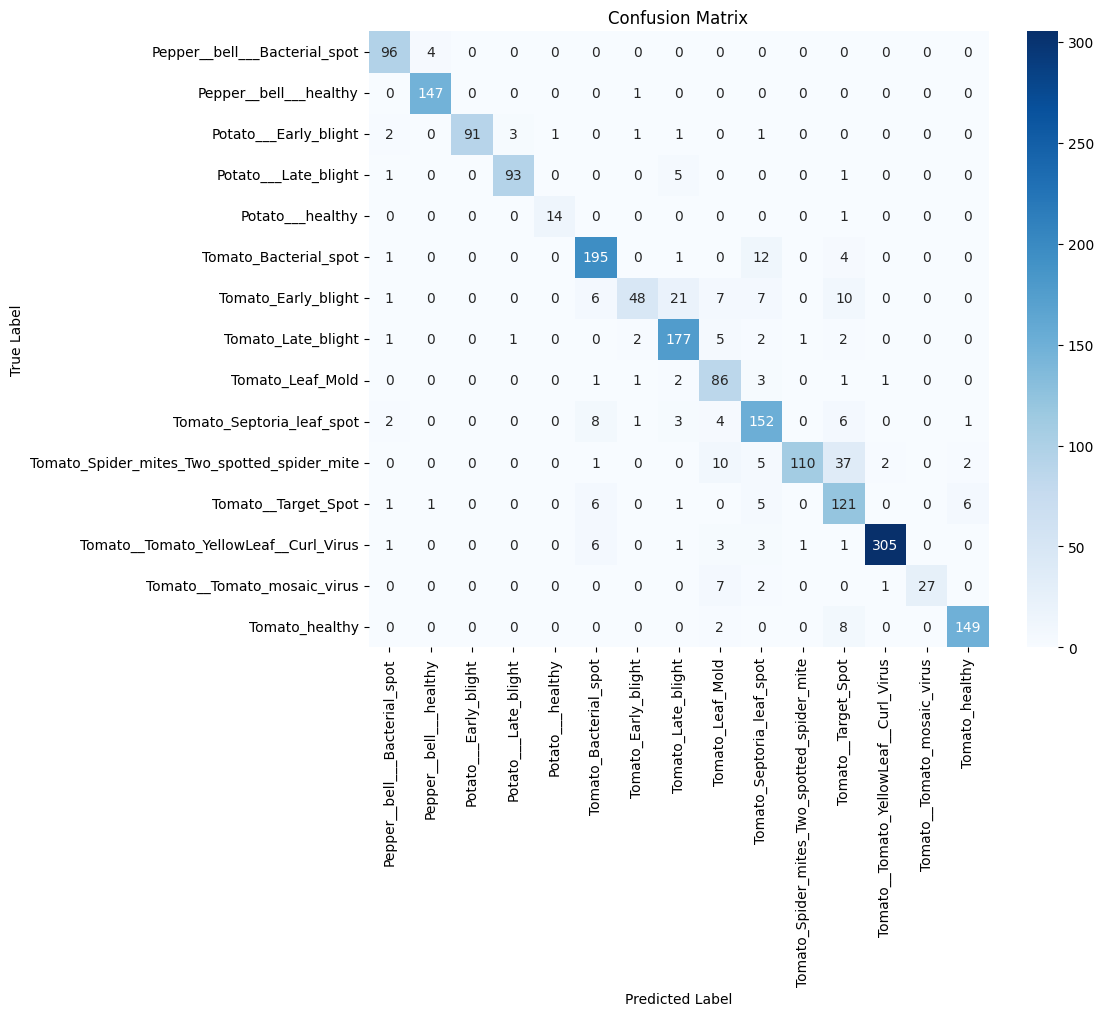

In [8]:
# Predict the labels on the test set
test_generator.reset() # Reset the generator to ensure consistent order
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1) # Add 1 for the last batch
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

accuracy = accuracy_score(true_classes, predicted_classes)

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
def get_model_size(model):
  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file)
  size_in_bytes = os.path.getsize(keras_file)
  os.remove(keras_file)
  return size_in_bytes

# Get the size of the model in bytes
model_size_bytes = get_model_size(model)

# Convert bytes to megabytes
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 9.35 MB


In [11]:
class SparsifyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                weights = layer.kernel
                mask = tf.math.abs(weights) >= self.threshold
                layer.kernel.assign(weights * tf.cast(mask, weights.dtype))

In [12]:
base_model_sparsified = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in base_model_sparsified.layers:
    layer.trainable = False

x_sparsified = base_model_sparsified.output
x_sparsified = GlobalAveragePooling2D()(x_sparsified)
predictions_sparsified = Dense(NUM_CLASSES, activation='softmax')(x_sparsified)

model_sparsified = Model(inputs=base_model_sparsified.input, outputs=predictions_sparsified)

model_sparsified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_sparsified.summary()

sparsity_threshold = 1e-3

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
sparsity_threshold = 1e-3

history_sparsified = model_sparsified.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS, # Train for the desired number of epochs
    callbacks=[SparsifyCallback(sparsity_threshold)]
)

print("New model trained with sparsification.")

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 278s 525ms/step - accuracy: 0.6064 - loss: 1.3169 - val_accuracy: 0.8311 - val_loss: 0.5639
Epoch 2/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.8125 - loss: 0.5677

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.5677 - val_accuracy: 0.8330 - val_loss: 0.5609
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 322s 536ms/step - accuracy: 0.8281 - loss: 0.5598 - val_accuracy: 0.8394 - val_loss: 0.4926
Epoch 4/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.9062 - loss: 0.4509

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9062 - loss: 0.4509 - val_accuracy: 0.8423 - val_loss: 0.4920
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 322s 543ms/step - accuracy: 0.8526 - loss: 0.4629 - val_accuracy: 0.8457 - val_loss: 0.4529
Epoch 6/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 52s 102ms/step - accuracy: 0.9062 - loss: 0.2624

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.2624 - val_accuracy: 0.8472 - val_loss: 0.4562
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 322s 550ms/step - accuracy: 0.8667 - loss: 0.4295 - val_accuracy: 0.8599 - val_loss: 0.4078
Epoch 8/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9062 - loss: 0.5054

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9062 - loss: 0.5054 - val_accuracy: 0.8594 - val_loss: 0.4111
Epoch 9/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 262s 509ms/step - accuracy: 0.8763 - loss: 0.3913 - val_accuracy: 0.8750 - val_loss: 0.3812
Epoch 10/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9062 - loss: 0.3965

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.3965 - val_accuracy: 0.8745 - val_loss: 0.3832
New model trained with sparsification.


65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step


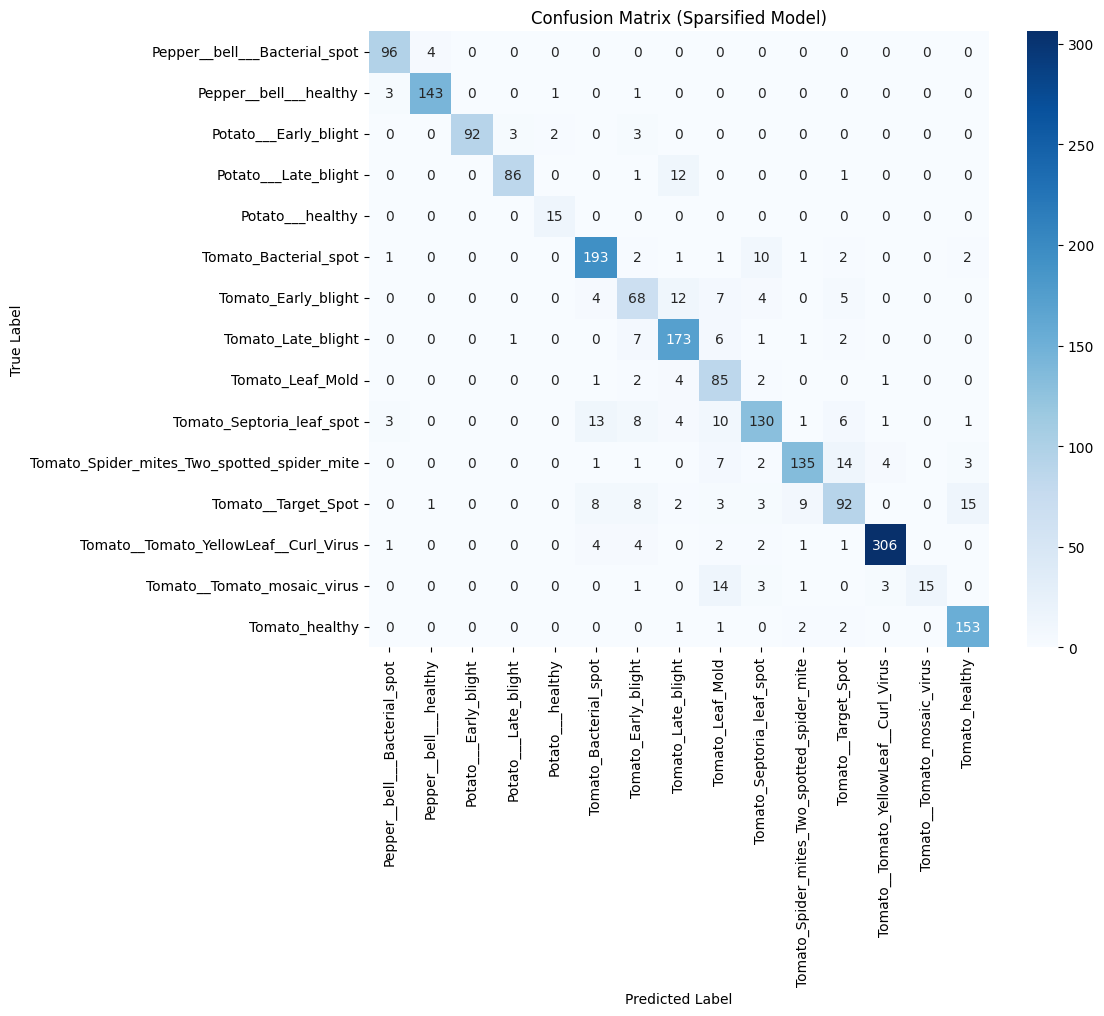

In [14]:
# Predict the labels on the test set using the sparsified model
test_generator.reset() # Reset the generator to ensure consistent order
predictions_sparsified = model_sparsified.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1) # Use model_sparsified
predicted_classes_sparsified = np.argmax(predictions_sparsified, axis=1)

# Get the true labels from the generator (these are the same for both models)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate metrics using the predictions from the sparsified model
accuracy_sparsified = accuracy_score(true_classes, predicted_classes_sparsified)

precision_sparsified = precision_score(true_classes, predicted_classes_sparsified, average='weighted')
recall_sparsified = recall_score(true_classes, predicted_classes_sparsified, average='weighted')
conf_matrix_sparsified = confusion_matrix(true_classes, predicted_classes_sparsified)

# Plot the confusion matrix for the sparsified model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_sparsified, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Sparsified Model)')
plt.show()

In [15]:
model_size_bytes_sparsified = get_model_size(model_sparsified)

model_size_mb_sparsified = model_size_bytes_sparsified / (1024 * 1024)

print(f"Model size: {model_size_mb_sparsified:.2f} MB")

Model size: 9.35 MB


In [16]:
model.save('mobilenetv2_model.h5')

In [17]:
def representative_data_gen():
    for _ in range(100):
        image, _ = next(iter(train_generator))
        yield [image.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Input/output settings
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

with open('mobilenetv2_int8.tflite', 'wb') as f:
    f.write(tflite_quant_model)


Saved artifact at '/tmp/tmprnhu7znj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139112528354896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528355664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528357008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528356624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528355088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112532620496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528356432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528355472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528357392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112528357200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1391125283577

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [18]:
model_size_mb = os.path.getsize('mobilenetv2_int8.tflite') / (1024 * 1024)
print(f"Rozmiar modelu: {model_size_mb:.2f} MB")

Rozmiar modelu: 2.60 MB


Accuracy of the TFLite INT8 model: 0.8328
Precision of the TFLite INT8 model: 0.8584
Recall of the TFLite INT8 model: 0.8328


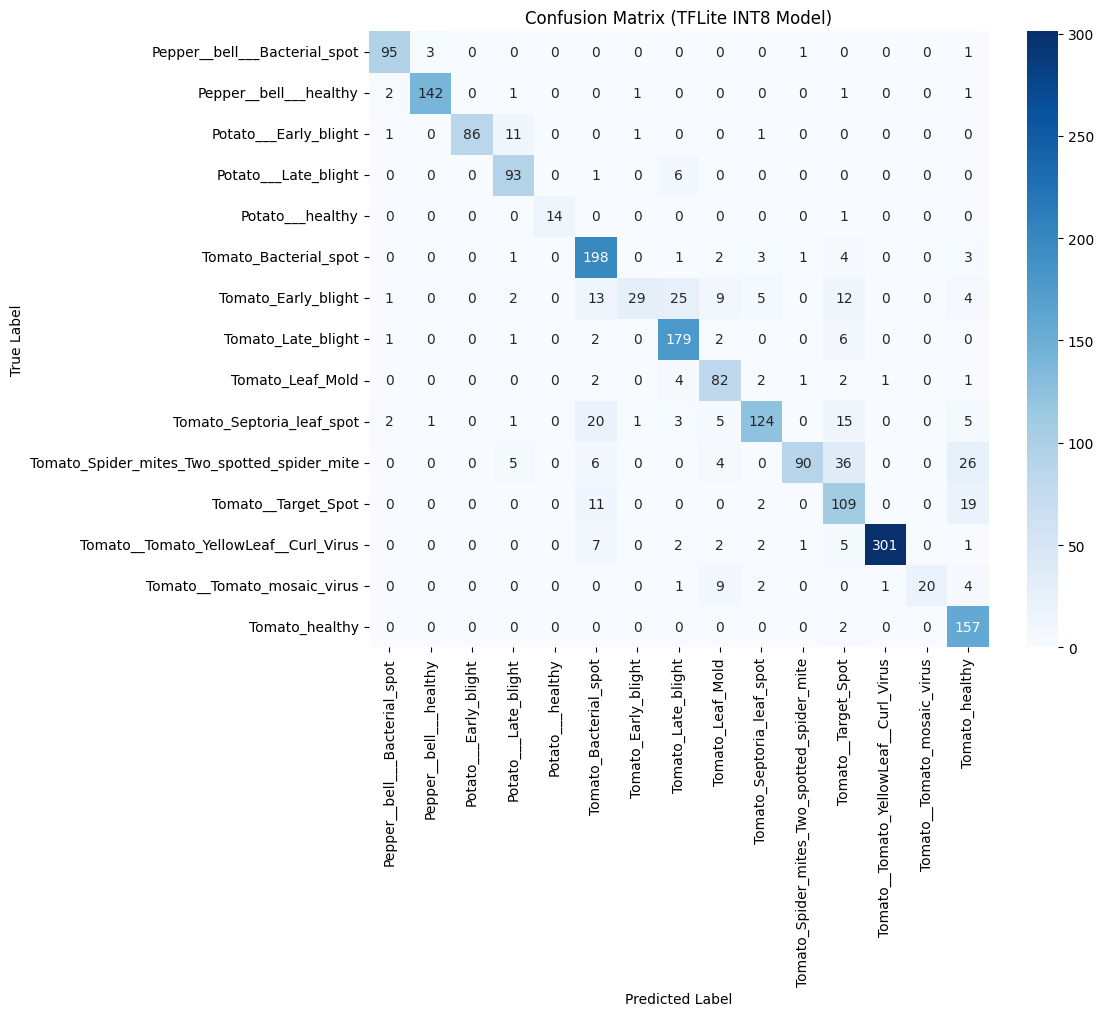

In [19]:
interpreter = tf.lite.Interpreter(model_path='mobilenetv2_int8.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_generator.reset()
all_predictions_tflite = []
all_true_labels = []

for i in range(len(test_generator)):
    images, labels = next(test_generator)

    input_data = (images * 255).astype(np.uint8)

    batch_predictions = []
    for j in range(input_data.shape[0]):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data[j], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        scale, zero_point = output_details[0]['quantization']
        dequantized_output = scale * (output_data - zero_point)

        batch_predictions.append(dequantized_output[0])

    all_predictions_tflite.extend(batch_predictions)
    all_true_labels.extend(np.argmax(labels, axis=1))

predicted_classes_tflite = np.argmax(all_predictions_tflite, axis=1)

accuracy_tflite = accuracy_score(all_true_labels, predicted_classes_tflite)
print(f"Accuracy of the TFLite INT8 model: {accuracy_tflite:.4f}")

precision_tflite = precision_score(all_true_labels, predicted_classes_tflite, average='weighted')
recall_tflite = recall_score(all_true_labels, predicted_classes_tflite, average='weighted')
conf_matrix_tflite = confusion_matrix(all_true_labels, predicted_classes_tflite)

print(f"Precision of the TFLite INT8 model: {precision_tflite:.4f}")
print(f"Recall of the TFLite INT8 model: {recall_tflite:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tflite, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TFLite INT8 Model)')
plt.show()

In [22]:
# Function to measure inference time for a given model
def measure_inference_time(model, generator, num_batches=None):
    start_time = time.time()
    if num_batches is None:
        num_batches = len(generator)
    for i in range(num_batches):
        images, _ = next(generator)
        model.predict(images)
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_batches
    avg_time_per_image = total_time / (num_batches * generator.batch_size)
    return total_time, avg_time_per_batch, avg_time_per_image

# Function to measure inference time for TFLite interpreter
def measure_inference_time_tflite(interpreter, generator, num_batches=None):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.allocate_tensors()

    start_time = time.time()
    if num_batches is None:
        num_batches = len(generator)

    for i in range(num_batches):
        images, _ = next(generator)
        input_data = (images * 255).astype(np.uint8) # Quantize input

        for j in range(input_data.shape[0]): # Process each image in the batch
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data[j], axis=0))
            interpreter.invoke()
            # Dequantization of output is not needed for timing measurement

    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_batches
    avg_time_per_image = total_time / (num_batches * generator.batch_size)
    return total_time, avg_time_per_batch, avg_time_per_image


# Reset the test generator for timing measurements
test_generator.reset()

# Measure inference time for the original model
print("Measuring inference time for the original model...")
original_model_total_time, original_model_avg_batch_time, original_model_avg_image_time = measure_inference_time(model, test_generator)
print(f"Original Model - Total Inference Time: {original_model_total_time:.4f} seconds")
print(f"Original Model - Average time per batch: {original_model_avg_batch_time:.4f} seconds")
print(f"Original Model - Average time per image: {original_model_avg_image_time:.4f} seconds")
print("-" * 30)

# Reset the test generator for timing measurements
test_generator.reset()

# Measure inference time for the sparsified model
print("Measuring inference time for the sparsified model...")
sparsified_model_total_time, sparsified_model_avg_batch_time, sparsified_model_avg_image_time = measure_inference_time(model_sparsified, test_generator)
print(f"Sparsified Model - Total Inference Time: {sparsified_model_total_time:.4f} seconds")
print(f"Sparsified Model - Average time per batch: {sparsified_model_avg_batch_time:.4f} seconds")
print(f"Sparsified Model - Average time per image: {sparsified_model_avg_image_time:.4f} seconds")
print("-" * 30)

# Reset the test generator for timing measurements
test_generator.reset()

# Measure inference time for the TFLite INT8 model
print("Measuring inference time for the TFLite INT8 model...")
interpreter = tf.lite.Interpreter(model_path='mobilenetv2_int8.tflite') # Re-create interpreter
tflite_model_total_time, tflite_model_avg_batch_time, tflite_model_avg_image_time = measure_inference_time_tflite(interpreter, test_generator)
print(f"TFLite INT8 Model - Total Inference Time: {tflite_model_total_time:.4f} seconds")
print(f"TFLite INT8 Model - Average time per batch: {tflite_model_avg_batch_time:.4f} seconds")
print(f"TFLite INT8 Model - Average time per image: {tflite_model_avg_image_time:.4f} seconds")
print("-" * 30)


Measuring inference time for the original model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms